In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
import plotnine
from plotnine import *
plotnine.options.figure_size = (12, 8)
warnings.simplefilter(action='ignore')
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction as ae

archives = ['../../ecotype_vs_chiclet/nantes_2020-06-08_199730.zip', '../../ecotype_vs_chiclet/lille_2020-06-08_1751710.zip']

f6e1abe82ebba1eec668652189985c631c10b5b5


In [2]:
df = pandas.concat([ae.read_performance(f) for f in archives])
df['mnk'] = df.m * df.n * df.k
df['gflops'] = 2*df['mnk'] / df['duration'] * 1e-9
df['cpu_id'] = df['node'].astype(str) + ':' + df['cpu'].astype(str)
print(len(df))
df.head()

87200


,function,m,n,k,timestamp,duration,core,node,cluster,jobid,cpu,start_time,index,expfile_hash,mnk,gflops,cpu_id
0,dgemm,1356,14731,501,349.464681,1.205803,0,34,ecotype,199730,0,1591625936,0,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,10007593236,16.599052,34:0
1,dgemm,562,10028,1418,350.670516,1.048557,0,34,ecotype,199730,0,1591625936,1,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,7991473648,15.242803,34:0
2,dgemm,3235,2932,457,351.719088,0.515131,0,34,ecotype,199730,0,1591625936,2,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,4334654140,16.829314,34:0
3,dgemm,10937,708,344,352.234232,0.328555,0,34,ecotype,199730,0,1591625936,3,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,2663728224,16.214809,34:0
4,dgemm,148,9841,5265,352.562800,1.162063,0,34,ecotype,199730,0,1591625936,4,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,7668304020,13.197742,34:0


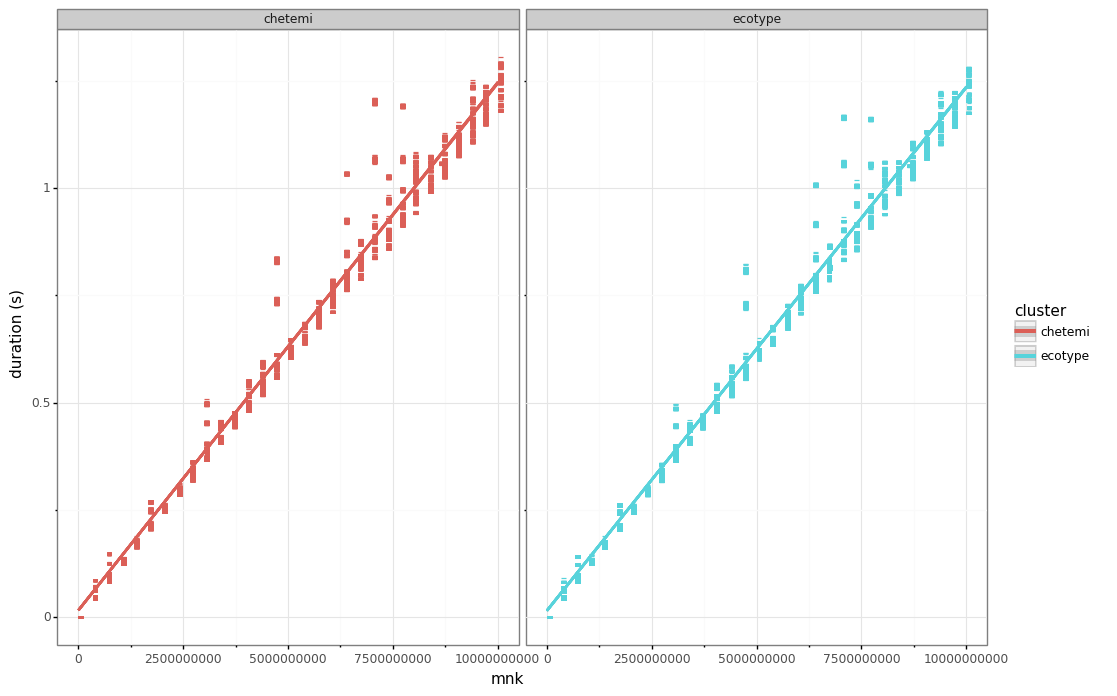

<ggplot: (-9223363290761657263)>

In [3]:
ggplot(df) +\
    aes(x='mnk', y='duration', color='cluster', group='cpu_id') +\
    geom_point(shape=1) +\
    geom_smooth(method='lm') +\
    facet_wrap('cluster') +\
    ylab('duration (s)') +\
    theme_bw()

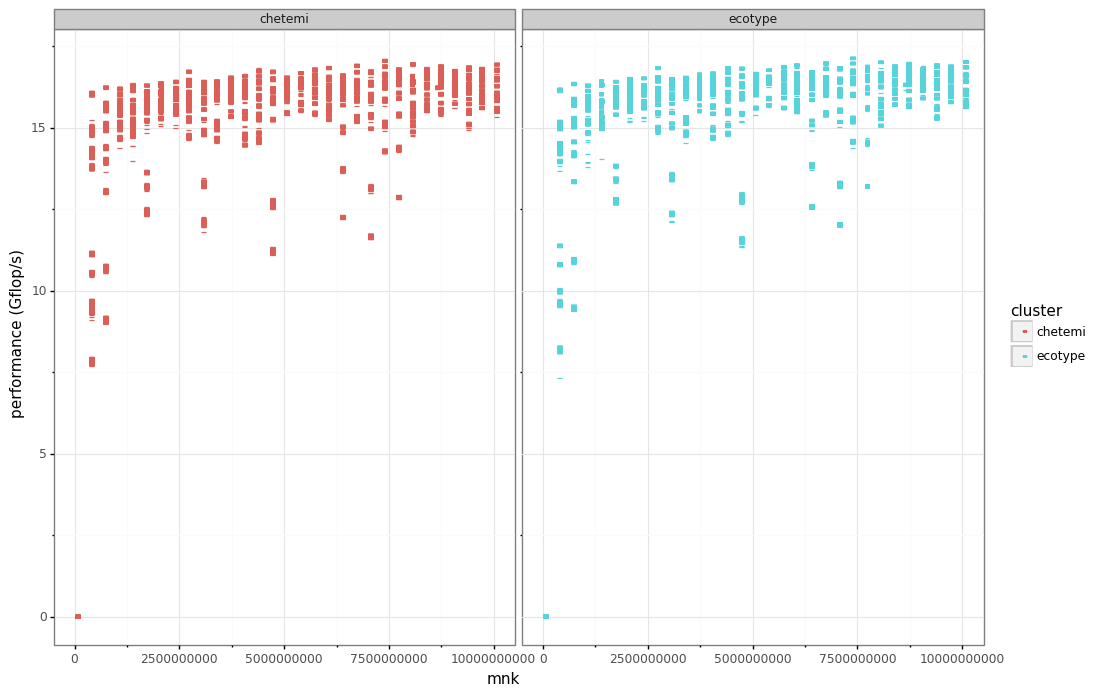

<ggplot: (8746092983293)>

In [4]:
ggplot(df) +\
    aes(x='mnk', y='gflops', color='cluster', group='cpu_id') +\
    geom_point(shape=1) +\
    facet_wrap('cluster') +\
    ylab('performance (Gflop/s)') +\
    theme_bw()

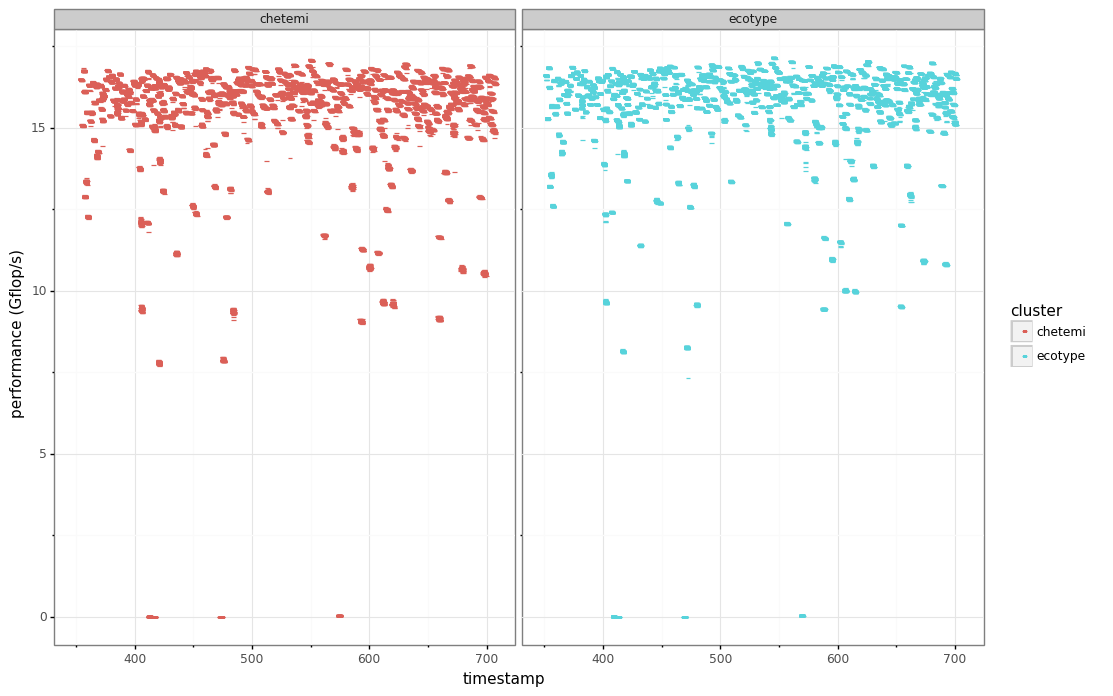

<ggplot: (-9223363290774622485)>

In [5]:
ggplot(df) +\
    aes(x='timestamp', y='gflops', color='cluster', group='cpu_id') +\
    geom_point(shape=1) +\
    facet_wrap('cluster') +\
    ylab('performance (Gflop/s)') +\
    theme_bw()

In [6]:
monitoring = pandas.concat([ae.read_monitoring(f) for f in archives])
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
print(len(monitoring))
monitoring.head()

46784


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,cpu_id
0,1.591633e+09,ecotype,34,199730,1591625936,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.999951,0,0,frequency,1.591634e+09,1.591635e+09,34:0
1,1.591633e+09,ecotype,34,199730,1591625936,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.201025,0,0,frequency,1.591634e+09,1.591635e+09,34:0
2,1.591633e+09,ecotype,34,199730,1591625936,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.599938,0,0,frequency,1.591634e+09,1.591635e+09,34:0
3,1.591633e+09,ecotype,34,199730,1591625936,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.599938,0,0,frequency,1.591634e+09,1.591635e+09,34:0
4,1.591633e+09,ecotype,34,199730,1591625936,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.599938,0,0,frequency,1.591634e+09,1.591635e+09,34:0


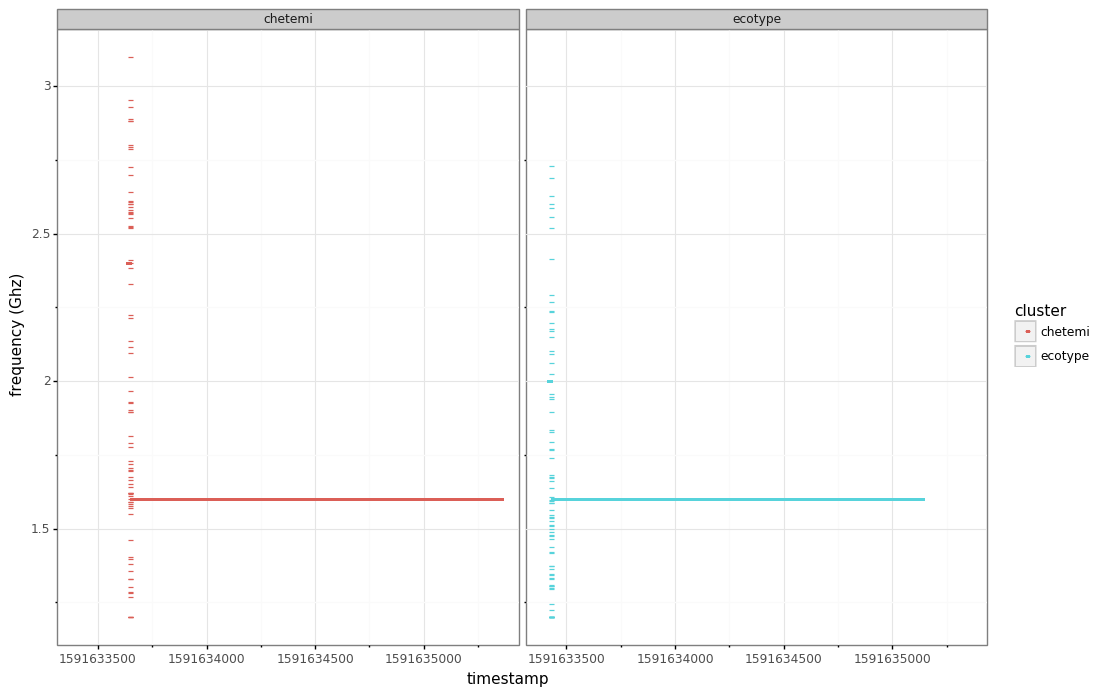

<ggplot: (-9223363290761727530)>

In [7]:
ggplot(monitoring[monitoring['kind'] == 'frequency']) +\
    aes(x='timestamp', y='value', color='cluster', group='cpu_id') +\
    geom_point(shape=1) +\
    facet_wrap('cluster') +\
    ylab('frequency (Ghz)') +\
    theme_bw()

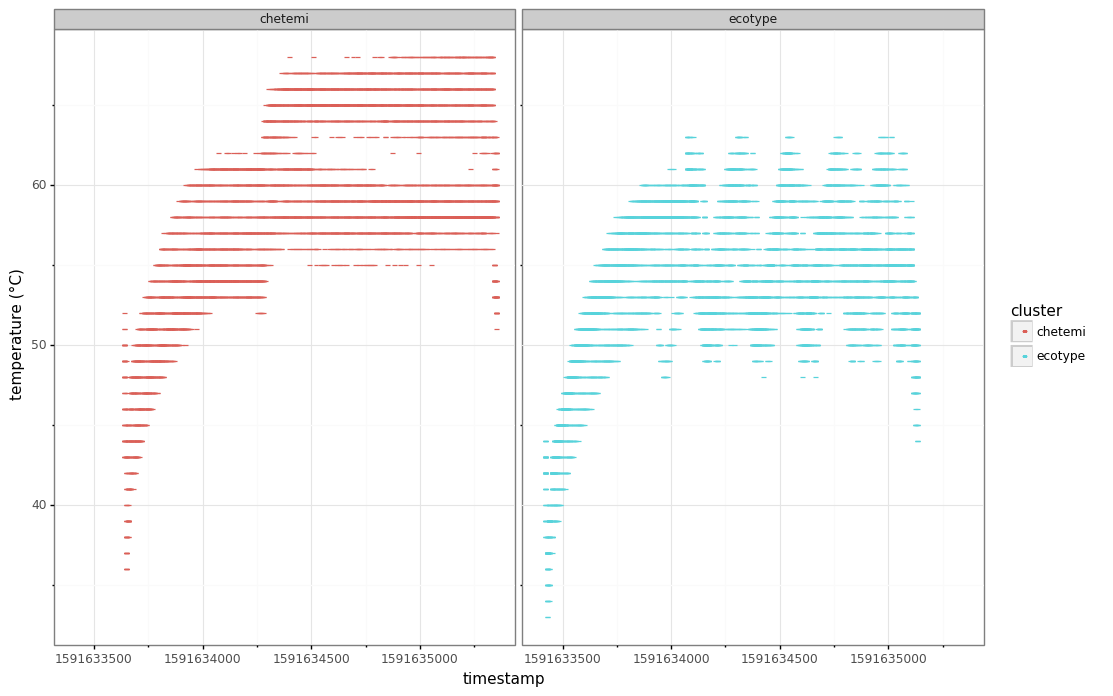

<ggplot: (8746094043270)>

In [8]:
ggplot(monitoring[monitoring['kind'] == 'temperature']) +\
    aes(x='timestamp', y='value', color='cluster', group='cpu_id') +\
    geom_point(shape=1) +\
    facet_wrap('cluster') +\
    ylab('temperature (°C)') +\
    theme_bw()

In [9]:
import numpy

def read_monitoring_power(archive_name, columns=None):
    '''
    Read the durations of a BLAS calibration in an archive.
    '''
    csv_name = 'monitoring.csv'
    df = ae.read_archive_csv_enhanced(archive_name, csv_name, columns=columns)
    df['timestamp'] = pandas.to_datetime(df['timestamp'])
    columns = ['timestamp', 'cluster', 'node', 'jobid', 'start_time', 'expfile_hash']
    power       = ae.my_melt(df, 'power_cpu_', columns)
    power['value'] = power['power_cpu_']
    power.drop('power_cpu_', axis=1, inplace=True)
    power['cpu'] = power['group']
    power['timestamp'] = power['timestamp'].astype(numpy.int64) / 10 ** 9
    return power

power = pandas.concat([read_monitoring_power(f) for f in archives])
power.head()

,timestamp,cluster,node,jobid,start_time,expfile_hash,group,value,cpu
0,1.591633e+09,ecotype,34,199730,1591625936,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,0,36.997259,0
1,1.591633e+09,ecotype,34,199730,1591625936,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,0,46.754303,0
2,1.591633e+09,ecotype,34,199730,1591625936,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,0,22.006082,0
3,1.591633e+09,ecotype,34,199730,1591625936,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,0,32.158057,0
4,1.591633e+09,ecotype,34,199730,1591625936,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,0,34.753819,0


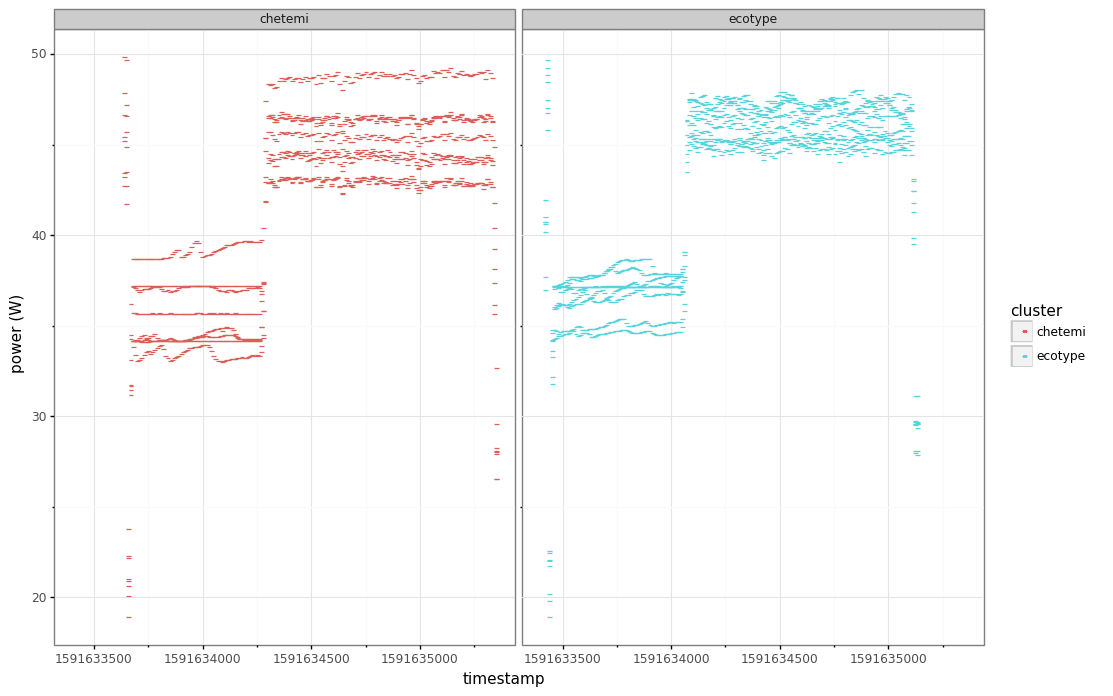

<ggplot: (8746083930537)>

In [10]:
ggplot(power) +\
    aes(x='timestamp', y='value', color='cluster') +\
    geom_point(shape=1) +\
    facet_wrap('cluster') +\
    ylab('power (W)') +\
    theme_bw()